# 행정동 세그먼트

In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

plt.rcdefaults()
plt.rcParams['axes.unicode_minus'] = False

In [37]:
dong_df = pd.read_excel(
    'E:/행정구역분류와 행정동(행정기관) 및 법정동코드 연계표(2023.01.01.기준).xlsx',
    sheet_name = '2-2. 연계표_행정동 및 법정동(기준시점)',
    header=1
)

gj_dong_df = dong_df[(dong_df['시군구'] == '광진구') & (dong_df['행정구역명'] != '광진구')][['행정기관코드', '행정구역명']]
gj_dong_df

C:\ProgramData\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,행정기관코드,행정구역명
252,1121571000,화양동
253,1121573000,군자동
254,1121574000,중곡1동
255,1121575000,중곡2동
256,1121576000,중곡3동
257,1121577000,중곡4동
258,1121578000,능동
259,1121581000,광장동
260,1121582000,자양1동
261,1121583000,자양2동


In [48]:
gj_dongs = gj_dong_df['행정기관코드'].astype(str).tolist()
len(gj_dongs)

15

In [4]:
closed_df = pd.read_csv('E:/행정동별 폐업률 zscore.csv', index_col=0)

In [68]:
root = 'E:/B079. 서울시민의 업종별 카드소비 데이터/2.파일데이터/SEOUL_SIMIN_07_VF/'
gj_sales_df = pd.DataFrame()

for i in range(366):
    now_date = datetime.datetime(2024, 1, 1) + datetime.timedelta(days=i)
    file = f'''{now_date.strftime('%Y%m')}/SEOUL_SIMIN_07_VF_{now_date.strftime('%Y%m%d')}.csv'''

    sales_df = pd.read_csv(root + file)
    gj_sales_df = pd.concat([
        gj_sales_df,
        sales_df[sales_df['가맹점행정동코드'].isin(gj_dongs)]\
            .groupby(['기준일자', '가맹점행정동코드'], as_index=False)['카드이용금액계'].sum()
    ])
    
    if (now_date + datetime.timedelta(days=1)).day == 1:
        print(f'''{now_date.strftime("%Y년 %m월")} 완료''')

2024년 01월 완료
2024년 02월 완료
2024년 03월 완료
2024년 04월 완료
2024년 05월 완료
2024년 06월 완료
2024년 07월 완료
2024년 08월 완료
2024년 09월 완료
2024년 10월 완료
2024년 11월 완료
2024년 12월 완료


In [ ]:
gj_sales_df = gj_sales_df.reset_index(drop=True)
gj_dongs_dict = gj_dong_df.set_index('행정기관코드').to_dict()['행정구역명']
gj_sales_df['행정동'] = gj_sales_df['가맹점행정동코드'].astype(int).map(gj_dongs_dict)

In [ ]:
sales_by_dong = gj_sales_df.groupby('행정동', as_index=False).agg({'카드이용금액계': 'sum'})

In [ ]:
people_df = pd.read_excel('E:/행정동별 생활인구 수 zscore.xlsx')

merged_df = pd.merge(
    left=people_df,
    right=sales_by_dong,
    left_on='region_name',
    right_on='행정동'
)[['행정동', 'total_population_2024', '카드이용금액계']]

In [ ]:
merged_df['sales_per_person'] = merged_df['카드이용금액계'] / merged_df['total_population_2024']
merged_df['z_score'] = (merged_df['sales_per_person'] - merged_df['sales_per_person'].mean()) / merged_df['sales_per_person'].std()

In [98]:
df = pd.merge(
    left=closed_df,
    right=merged_df,
    on='행정동'
)[['행정동', '단기_zscore', 'z_score']].rename(columns={'단기_zscore': '폐업률_zscore', 'z_score': '생활인구당_매출_zscore'})

df

,행정동,폐업률_zscore,생활인구당_매출_zscore
0,광장동,0.721197,-0.491242
1,구의1동,-1.779446,-0.465734
2,구의2동,-0.130172,-0.627401
3,구의3동,-0.685325,2.861944
4,군자동,2.280819,-0.469480
5,능동,-0.217813,0.207316
6,자양1동,0.529290,0.113879
7,자양2동,-1.254286,-0.724784
8,자양3동,1.225563,0.735624
9,자양4동,0.086899,-0.191592


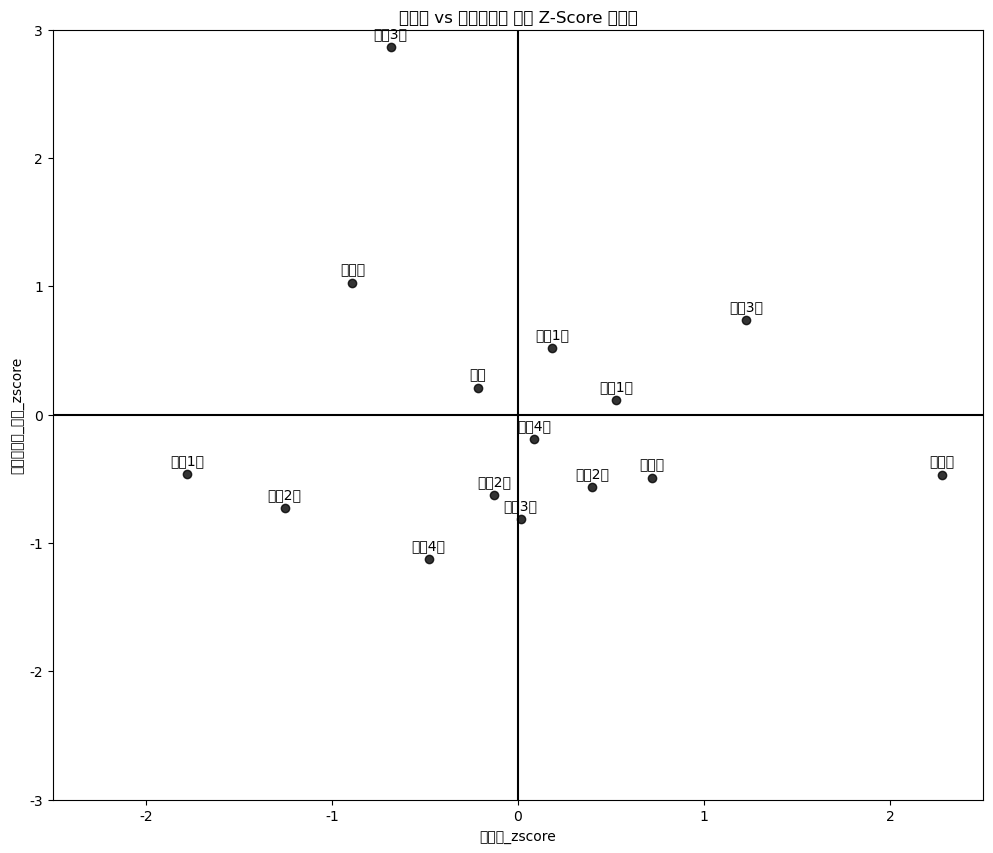

In [133]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(12, 10))
plt.scatter(df['폐업률_zscore'], df['생활인구당_매출_zscore'], marker='o', alpha=0.8, color='black')

for _, row in df.iterrows():
    plt.text(
        row['폐업률_zscore'],
        row['생활인구당_매출_zscore'] + 0.05,
        row['행정동'],
        fontsize=10,
        va='bottom',
        ha='center'
    )

plt.xlabel('폐업률_zscore')
plt.ylabel('생활인구당_매출_zscore')
plt.title('폐업률 vs 생활인구당 매출 Z-Score 산점도')
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.xlim(-2.5, 2.5)
plt.ylim(-3, 3)
plt.show()

In [134]:
df['지역 세그먼트'] = df.apply(
    lambda x: '과도기 지역군' if x['폐업률_zscore'] >= 0 and x['생활인구당_매출_zscore'] >= 0
    else '안정 성장 지역군' if x['폐업률_zscore'] < 0 and x['생활인구당_매출_zscore'] >= 0
    else '위험 지역군' if x['폐업률_zscore'] >= 0 and x['생활인구당_매출_zscore'] < 0
    else '잠재 성장 지역군',
    axis=1
)

df

,행정동,폐업률_zscore,생활인구당_매출_zscore,지역 세그먼트
0,광장동,0.721197,-0.491242,위험 지역군
1,구의1동,-1.779446,-0.465734,잠재 성장 지역군
2,구의2동,-0.130172,-0.627401,잠재 성장 지역군
3,구의3동,-0.685325,2.861944,안정 성장 지역군
4,군자동,2.280819,-0.469480,위험 지역군
5,능동,-0.217813,0.207316,안정 성장 지역군
6,자양1동,0.529290,0.113879,과도기 지역군
7,자양2동,-1.254286,-0.724784,잠재 성장 지역군
8,자양3동,1.225563,0.735624,과도기 지역군
9,자양4동,0.086899,-0.191592,위험 지역군


In [135]:
df.to_csv('행정동별_세그먼트.csv')